# TensorFlow_v2: Train ConvNet + CIFAR-10
This notebook is my own cleaned-up version of `TensorFlow.ipynb` notebook. The goal is to train a ConvNet that can acheive 70% accuracy on the validation set.

Things to do in this note:

Model and training:
- [x] Define a model graph with deeper network architecture:
    - Use smaller conv filters since the images are small
    - Adjust the number of filters
- [x] Use BN after conv layer and affine layer
- [ ] Use learning rate decay
- [ ] Add L2 regularisation and dropout

Implementation:
- [x] Use `tf.layer` lever API, which makes implementation easier

Hyperparameter tuning:
- [ ] Determine the hyperparameters needed
- [ ] Automated hyperparameter search: 
    - [ ] Coarse search hyperparameters with grid search
    - [ ] Fine search hyperparameters with random search


### Tips for training
For each network architecture that you try, you should tune the learning rate and regularization strength. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and we'll save the test set for evaluating your architecture on the best pa

## Loading libraries

In [1]:
import tensorflow as tf
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
from cs231n.my_util import run_model 
%matplotlib inline

## Load CIFAR-10 data

### Use this custom data loading for now

In [2]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    # Notice that we subtract the mean image calculated on training set
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Solver: `run_model()`


In [3]:
def run_model(session, predict, loss_val, Xd, yd,
              epochs=1, batch_size=64, print_every=100,
              training=None, plot_losses=False):
    # have tensorflow compute accuracy
    correct_prediction = tf.equal(tf.argmax(predict,1), y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    
    # shuffle indicies
    train_indicies = np.arange(Xd.shape[0])
    np.random.shuffle(train_indicies)

    training_now = training is not None
    
    # setting up variables we want to compute (and optimizing)
    # if we have a training function, add that to things we compute
    variables = [mean_loss,correct_prediction,accuracy]
    if training_now:
        variables[-1] = training
    
    # counter 
    iter_cnt = 0
    for e in range(epochs):
        # keep track of losses and accuracy
        correct = 0
        losses = [] 
        # make sure we iterate over the dataset once
        for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
            # generate indicies for the batch
            start_idx = (i*batch_size)%Xd.shape[0]  #why remainder?
            idx = train_indicies[start_idx:start_idx+batch_size]
            
            # create a feed dictionary for this batch
            feed_dict = {X: Xd[idx,:],
                         y: yd[idx],
                         is_training: training_now }
            # get batch size
            actual_batch_size = yd[idx].shape[0]
            
            # have tensorflow compute loss and correct predictions
            # and (if given) perform a training step
            loss, corr, _ = session.run(variables,feed_dict=feed_dict)
            
            # aggregate performance stats
            losses.append(loss*actual_batch_size)
            correct += np.sum(corr)
            
            # print every now and then
            if training_now and (iter_cnt % print_every) == 0:
                print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                      .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
            iter_cnt += 1
        total_correct = correct/Xd.shape[0]
        total_loss = np.sum(losses)/Xd.shape[0]
        print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
              .format(total_loss,total_correct,e+1))
        if plot_losses:
            plt.plot(losses)
            plt.grid(True)
            plt.title('Epoch {} Loss'.format(e+1))
            plt.xlabel('minibatch number')
            plt.ylabel('minibatch loss')
            plt.show()
    return total_loss,total_correct

## Model, Optimizer and Training
Architecture:
- [conv-relu-BN-conv-relu-BN-pool] 1
    - conv: 32 5x5 filters, stride 1, padding VALID
    - pool: 2x2 max pooling, stride 2
- [conv-relu-BN-conv-relu-BN-pool] 2
    - conv: 64 3x3 filters, stride 1, padding SAME
    - pool: 2x2 max pooling, stride 2
- [affine-BN-relu]
    - affine1: 1024 output
- affine
- softmax loss

Optimizer: Adam

Number of parameters:
- [conv-relu-BN-conv-relu-BN-pool] 1:
    - conv: 1600 = 800x2
    - BN: 64 = 2x32 ($\gamma$, $\beta$ of $C$ channels)
- [conv-relu-BN-conv-relu-BN-pool] 2:
    - conv: 1152 = 576x2
    - BN: 128 = 2x64
- [affine-BN-relu]:
    - affine 1: 2,359,296 = 2304x1024
- [affine] 2: 10,240 = 1024x10


In [4]:
# Feel free to play with this cell

def my_model(X,y,is_training):
    
    # conv1-relu-bn
    conv1_relu = tf.layers.conv2d(X, 32, [5, 5], 
                             strides=(1, 1), 
                             padding='valid',
                            activation=tf.nn.relu)
    bn1 = tf.layers.batch_normalization(conv1_relu)
    
    # conv2-relu-bn
    conv2_relu = tf.layers.conv2d(conv1_relu, 32, [5, 5], 
                             strides=(1, 1), 
                             padding='valid',
                            activation=tf.nn.relu)
    bn2 = tf.layers.batch_normalization(conv2_relu)
    
    # max pool
    max_pool1 = tf.layers.max_pooling2d(bn2, [2, 2], (2, 2))
    
    # conv3-bn-relu
    conv3_relu = tf.layers.conv2d(max_pool1, 64, [3, 3],
                            strides=(1, 1),
                            padding='same',
                            activation=tf.nn.relu)
    bn3 = tf.layers.batch_normalization(conv3_relu)
    
    # conv4-bn-relu
    conv4_relu = tf.layers.conv2d(bn3, 64, [3, 3],
                            strides=(1, 1),
                            padding='same',
                            activation=tf.nn.relu)
    bn4 = tf.layers.batch_normalization(conv4_relu)
    
    # max pool
    max_pool2 = tf.layers.max_pooling2d(bn4, [2, 2], (2, 2))
    
    # affine1-bn-relu
    max_pool2_flat = tf.reshape(max_pool2, [-1, 6 * 6 * 64])
    affine_relu1 = tf.layers.dense(max_pool2_flat, 1024, activation=tf.nn.relu)
    
    # affine2
    y_out = tf.layers.dense(affine_relu1, 10)
    
    return y_out
    

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = my_model(X,y,is_training)
total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y, 10), logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

# set up optimizer
learning_rate = 5e-4
optimizer = tf.train.AdamOptimizer(learning_rate)


# pass?

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)

Training
Iteration 0: with minibatch training loss = 9.36 and accuracy of 0.094
Iteration 100: with minibatch training loss = 1.83 and accuracy of 0.34
Iteration 200: with minibatch training loss = 1.56 and accuracy of 0.5
Iteration 300: with minibatch training loss = 1.4 and accuracy of 0.47
Iteration 400: with minibatch training loss = 1.38 and accuracy of 0.52
Iteration 500: with minibatch training loss = 1.4 and accuracy of 0.5
Iteration 600: with minibatch training loss = 1.21 and accuracy of 0.52
Iteration 700: with minibatch training loss = 1.4 and accuracy of 0.52
Epoch 1, Overall loss = 1.66 and accuracy of 0.444


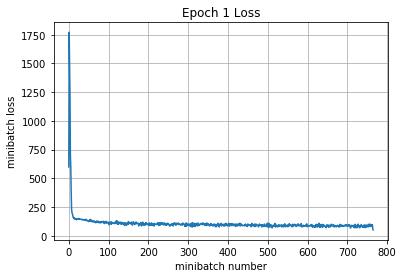

Iteration 800: with minibatch training loss = 1.24 and accuracy of 0.62
Iteration 900: with minibatch training loss = 1.44 and accuracy of 0.42
Iteration 1000: with minibatch training loss = 1.38 and accuracy of 0.53
Iteration 1100: with minibatch training loss = 1.2 and accuracy of 0.59
Iteration 1200: with minibatch training loss = 1.34 and accuracy of 0.58
Iteration 1300: with minibatch training loss = 1.11 and accuracy of 0.67
Iteration 1400: with minibatch training loss = 1.18 and accuracy of 0.56
Iteration 1500: with minibatch training loss = 0.906 and accuracy of 0.72
Epoch 2, Overall loss = 1.12 and accuracy of 0.602


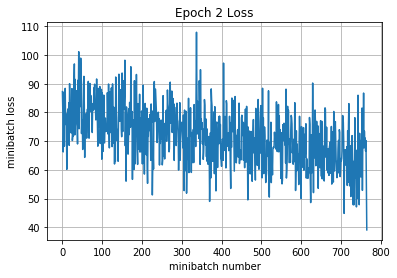

Iteration 1600: with minibatch training loss = 0.85 and accuracy of 0.69
Iteration 1700: with minibatch training loss = 0.909 and accuracy of 0.7
Iteration 1800: with minibatch training loss = 0.765 and accuracy of 0.72
Iteration 1900: with minibatch training loss = 0.812 and accuracy of 0.77
Iteration 2000: with minibatch training loss = 0.886 and accuracy of 0.72
Iteration 2100: with minibatch training loss = 0.971 and accuracy of 0.7
Iteration 2200: with minibatch training loss = 0.579 and accuracy of 0.78
Epoch 3, Overall loss = 0.84 and accuracy of 0.707


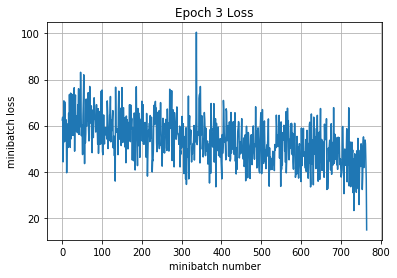

Iteration 2300: with minibatch training loss = 0.505 and accuracy of 0.83
Iteration 2400: with minibatch training loss = 0.503 and accuracy of 0.83
Iteration 2500: with minibatch training loss = 0.672 and accuracy of 0.77
Iteration 2600: with minibatch training loss = 0.464 and accuracy of 0.83
Iteration 2700: with minibatch training loss = 0.786 and accuracy of 0.75
Iteration 2800: with minibatch training loss = 0.524 and accuracy of 0.84
Iteration 2900: with minibatch training loss = 0.317 and accuracy of 0.91
Iteration 3000: with minibatch training loss = 0.544 and accuracy of 0.78
Epoch 4, Overall loss = 0.599 and accuracy of 0.791


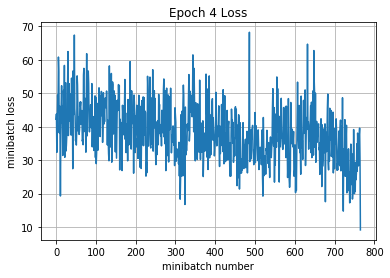

Iteration 3100: with minibatch training loss = 0.354 and accuracy of 0.88
Iteration 3200: with minibatch training loss = 0.294 and accuracy of 0.91
Iteration 3300: with minibatch training loss = 0.581 and accuracy of 0.81
Iteration 3400: with minibatch training loss = 0.415 and accuracy of 0.86
Iteration 3500: with minibatch training loss = 0.403 and accuracy of 0.81
Iteration 3600: with minibatch training loss = 0.602 and accuracy of 0.81
Iteration 3700: with minibatch training loss = 0.512 and accuracy of 0.81
Iteration 3800: with minibatch training loss = 0.271 and accuracy of 0.97
Epoch 5, Overall loss = 0.445 and accuracy of 0.845


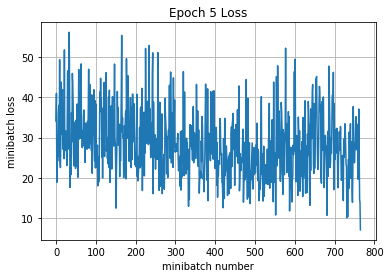

Iteration 0: with minibatch training loss = 0.504 and accuracy of 0.8
Iteration 100: with minibatch training loss = 0.153 and accuracy of 0.95
Iteration 200: with minibatch training loss = 0.325 and accuracy of 0.89
Iteration 300: with minibatch training loss = 0.261 and accuracy of 0.86
Iteration 400: with minibatch training loss = 0.399 and accuracy of 0.81
Iteration 500: with minibatch training loss = 0.335 and accuracy of 0.88
Iteration 600: with minibatch training loss = 0.411 and accuracy of 0.83
Iteration 700: with minibatch training loss = 0.498 and accuracy of 0.83
Epoch 1, Overall loss = 0.357 and accuracy of 0.875


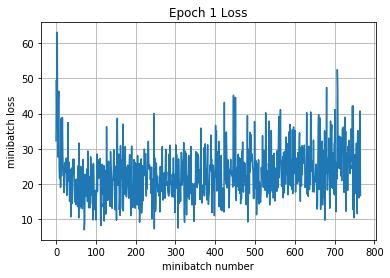

Iteration 800: with minibatch training loss = 0.238 and accuracy of 0.92
Iteration 900: with minibatch training loss = 0.103 and accuracy of 0.95
Iteration 1000: with minibatch training loss = 0.0883 and accuracy of 0.97
Iteration 1100: with minibatch training loss = 0.151 and accuracy of 0.94
Iteration 1200: with minibatch training loss = 0.104 and accuracy of 0.95
Iteration 1300: with minibatch training loss = 0.264 and accuracy of 0.92
Iteration 1400: with minibatch training loss = 0.13 and accuracy of 0.97
Iteration 1500: with minibatch training loss = 0.279 and accuracy of 0.89
Epoch 2, Overall loss = 0.152 and accuracy of 0.949


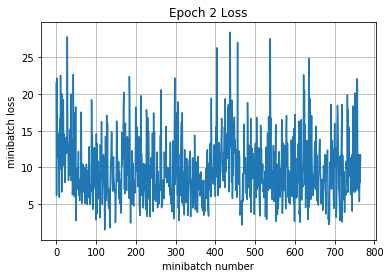

Iteration 1600: with minibatch training loss = 0.0651 and accuracy of 0.98
Iteration 1700: with minibatch training loss = 0.324 and accuracy of 0.95
Iteration 1800: with minibatch training loss = 0.27 and accuracy of 0.89
Iteration 1900: with minibatch training loss = 0.196 and accuracy of 0.94
Iteration 2000: with minibatch training loss = 0.0734 and accuracy of 0.95
Iteration 2100: with minibatch training loss = 0.0509 and accuracy of 0.98
Iteration 2200: with minibatch training loss = 0.0615 and accuracy of 0.98
Epoch 3, Overall loss = 0.132 and accuracy of 0.956


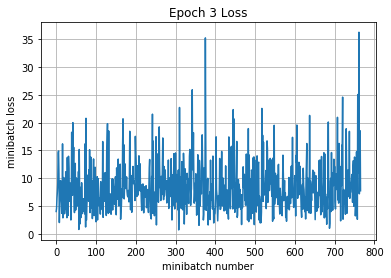

Iteration 2300: with minibatch training loss = 0.183 and accuracy of 0.97
Iteration 2400: with minibatch training loss = 0.0931 and accuracy of 0.98
Iteration 2500: with minibatch training loss = 0.157 and accuracy of 0.94
Iteration 2600: with minibatch training loss = 0.179 and accuracy of 0.97
Iteration 2700: with minibatch training loss = 0.0832 and accuracy of 0.97
Iteration 2800: with minibatch training loss = 0.13 and accuracy of 0.95
Iteration 2900: with minibatch training loss = 0.126 and accuracy of 0.95
Iteration 3000: with minibatch training loss = 0.0918 and accuracy of 0.97
Epoch 4, Overall loss = 0.136 and accuracy of 0.954


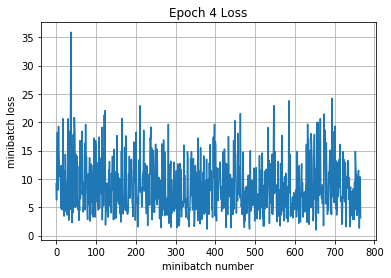

Iteration 3100: with minibatch training loss = 0.0754 and accuracy of 0.97
Iteration 3200: with minibatch training loss = 0.036 and accuracy of 1
Iteration 3300: with minibatch training loss = 0.154 and accuracy of 0.94
Iteration 3400: with minibatch training loss = 0.0631 and accuracy of 0.98
Iteration 3500: with minibatch training loss = 0.0991 and accuracy of 0.95
Iteration 3600: with minibatch training loss = 0.0547 and accuracy of 0.98
Iteration 3700: with minibatch training loss = 0.14 and accuracy of 0.98
Iteration 3800: with minibatch training loss = 0.0904 and accuracy of 0.95
Epoch 5, Overall loss = 0.122 and accuracy of 0.959


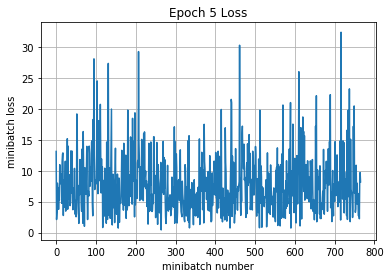

Iteration 0: with minibatch training loss = 0.189 and accuracy of 0.95
Iteration 100: with minibatch training loss = 0.239 and accuracy of 0.94
Iteration 200: with minibatch training loss = 0.0424 and accuracy of 0.97
Iteration 300: with minibatch training loss = 0.0809 and accuracy of 0.95
Iteration 400: with minibatch training loss = 0.224 and accuracy of 0.94
Iteration 500: with minibatch training loss = 0.0916 and accuracy of 0.95
Iteration 600: with minibatch training loss = 0.126 and accuracy of 0.92
Iteration 700: with minibatch training loss = 0.144 and accuracy of 0.95
Epoch 1, Overall loss = 0.127 and accuracy of 0.958


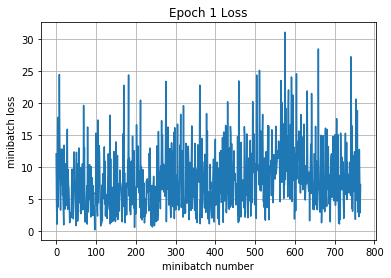

Iteration 800: with minibatch training loss = 0.308 and accuracy of 0.89
Iteration 900: with minibatch training loss = 0.0599 and accuracy of 0.97
Iteration 1000: with minibatch training loss = 0.0726 and accuracy of 0.98
Iteration 1100: with minibatch training loss = 0.0778 and accuracy of 0.98
Iteration 1200: with minibatch training loss = 0.0545 and accuracy of 0.97
Iteration 1300: with minibatch training loss = 0.0778 and accuracy of 0.98
Iteration 1400: with minibatch training loss = 0.0713 and accuracy of 0.98
Iteration 1500: with minibatch training loss = 0.243 and accuracy of 0.92
Epoch 2, Overall loss = 0.0985 and accuracy of 0.968


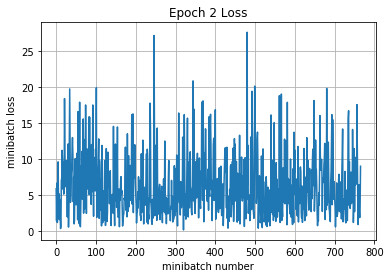

Iteration 1600: with minibatch training loss = 0.068 and accuracy of 0.98
Iteration 1700: with minibatch training loss = 0.0532 and accuracy of 0.97
Iteration 1800: with minibatch training loss = 0.109 and accuracy of 0.97
Iteration 1900: with minibatch training loss = 0.0156 and accuracy of 1
Iteration 2000: with minibatch training loss = 0.219 and accuracy of 0.94
Iteration 2100: with minibatch training loss = 0.13 and accuracy of 0.94
Iteration 2200: with minibatch training loss = 0.262 and accuracy of 0.92
Epoch 3, Overall loss = 0.0915 and accuracy of 0.971


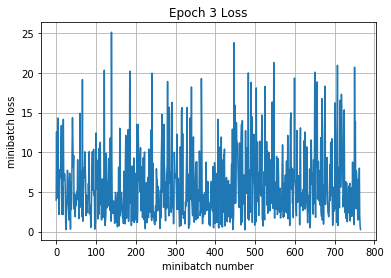

Iteration 2300: with minibatch training loss = 0.0139 and accuracy of 1
Iteration 2400: with minibatch training loss = 0.0619 and accuracy of 0.97
Iteration 2500: with minibatch training loss = 0.134 and accuracy of 0.94
Iteration 2600: with minibatch training loss = 0.261 and accuracy of 0.92
Iteration 2700: with minibatch training loss = 0.153 and accuracy of 0.95
Iteration 2800: with minibatch training loss = 0.0456 and accuracy of 1
Iteration 2900: with minibatch training loss = 0.0458 and accuracy of 1
Iteration 3000: with minibatch training loss = 0.0673 and accuracy of 0.95
Epoch 4, Overall loss = 0.1 and accuracy of 0.968


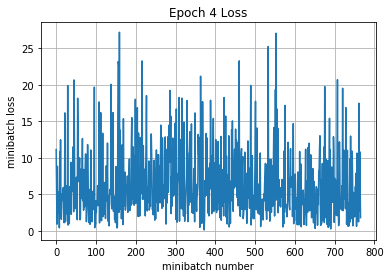

Iteration 3100: with minibatch training loss = 0.0647 and accuracy of 0.97
Iteration 3200: with minibatch training loss = 0.0979 and accuracy of 0.95
Iteration 3300: with minibatch training loss = 0.0213 and accuracy of 1
Iteration 3400: with minibatch training loss = 0.0716 and accuracy of 0.97
Iteration 3500: with minibatch training loss = 0.0497 and accuracy of 0.97
Iteration 3600: with minibatch training loss = 0.0206 and accuracy of 1
Iteration 3700: with minibatch training loss = 0.111 and accuracy of 0.95
Iteration 3800: with minibatch training loss = 0.0875 and accuracy of 0.97
Epoch 5, Overall loss = 0.0865 and accuracy of 0.972


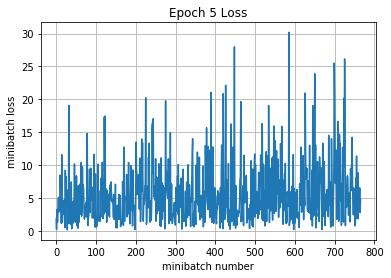

Iteration 0: with minibatch training loss = 0.17 and accuracy of 0.95
Iteration 100: with minibatch training loss = 0.0251 and accuracy of 0.98
Iteration 200: with minibatch training loss = 0.034 and accuracy of 0.98
Iteration 300: with minibatch training loss = 0.126 and accuracy of 0.98
Iteration 400: with minibatch training loss = 0.00956 and accuracy of 1
Iteration 500: with minibatch training loss = 0.188 and accuracy of 0.94
Iteration 600: with minibatch training loss = 0.0915 and accuracy of 0.98
Iteration 700: with minibatch training loss = 0.0813 and accuracy of 0.97
Epoch 1, Overall loss = 0.0887 and accuracy of 0.972


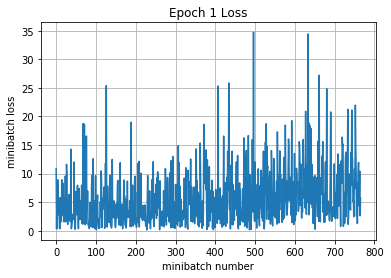

Iteration 800: with minibatch training loss = 0.025 and accuracy of 1
Iteration 900: with minibatch training loss = 0.0493 and accuracy of 0.98
Iteration 1000: with minibatch training loss = 0.0429 and accuracy of 0.98
Iteration 1100: with minibatch training loss = 0.094 and accuracy of 0.97
Iteration 1200: with minibatch training loss = 0.16 and accuracy of 0.97
Iteration 1300: with minibatch training loss = 0.0151 and accuracy of 0.98
Iteration 1400: with minibatch training loss = 0.0531 and accuracy of 0.98
Iteration 1500: with minibatch training loss = 0.0252 and accuracy of 1
Epoch 2, Overall loss = 0.0891 and accuracy of 0.972


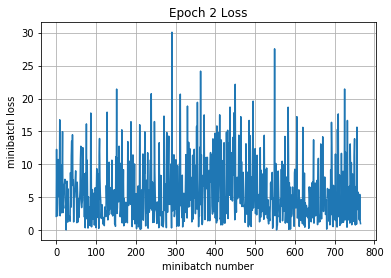

Iteration 1600: with minibatch training loss = 0.0257 and accuracy of 1
Iteration 1700: with minibatch training loss = 0.0235 and accuracy of 1
Iteration 1800: with minibatch training loss = 0.151 and accuracy of 0.97
Iteration 1900: with minibatch training loss = 0.202 and accuracy of 0.94
Iteration 2000: with minibatch training loss = 0.00474 and accuracy of 1
Iteration 2100: with minibatch training loss = 0.0433 and accuracy of 0.98
Iteration 2200: with minibatch training loss = 0.127 and accuracy of 0.97
Epoch 3, Overall loss = 0.071 and accuracy of 0.978


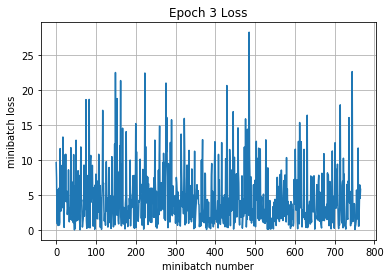

Iteration 2300: with minibatch training loss = 0.165 and accuracy of 0.94
Iteration 2400: with minibatch training loss = 0.0134 and accuracy of 1
Iteration 2500: with minibatch training loss = 0.061 and accuracy of 0.97
Iteration 2600: with minibatch training loss = 0.0361 and accuracy of 0.98
Iteration 2700: with minibatch training loss = 0.0495 and accuracy of 0.98
Iteration 2800: with minibatch training loss = 0.0218 and accuracy of 1
Iteration 2900: with minibatch training loss = 0.0548 and accuracy of 0.97
Iteration 3000: with minibatch training loss = 0.165 and accuracy of 0.98
Epoch 4, Overall loss = 0.072 and accuracy of 0.978


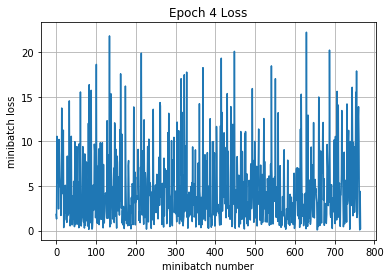

Iteration 3100: with minibatch training loss = 0.00969 and accuracy of 1
Iteration 3200: with minibatch training loss = 0.0396 and accuracy of 0.97
Iteration 3300: with minibatch training loss = 0.0437 and accuracy of 0.98
Iteration 3400: with minibatch training loss = 0.0906 and accuracy of 0.95
Iteration 3500: with minibatch training loss = 0.149 and accuracy of 0.97
Iteration 3600: with minibatch training loss = 0.00581 and accuracy of 1
Iteration 3700: with minibatch training loss = 0.104 and accuracy of 0.98
Iteration 3800: with minibatch training loss = 0.265 and accuracy of 0.94
Epoch 5, Overall loss = 0.0707 and accuracy of 0.978


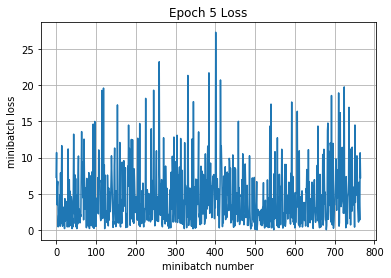

1 loops, best of 3: 41.4 s per loop
Validation
Epoch 1, Overall loss = 2.7 and accuracy of 0.634


In [7]:
# Feel free to play with this cell
# This default code creates a session
# and trains your model for 10 epochs
# then prints the validation set accuracy
sess = tf.Session()
with tf.device("/cpu:0"):
    sess.run(tf.global_variables_initializer())
    print('Training')
    %timeit run_model(sess,y_out,mean_loss,X_train,y_train,5,64,100,train_step,True)
    print('Validation')
    run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Training
Iteration 0: with minibatch training loss = 9 and accuracy of 0.14
Iteration 100: with minibatch training loss = 2.05 and accuracy of 0.3
Iteration 200: with minibatch training loss = 1.4 and accuracy of 0.48
Iteration 300: with minibatch training loss = 1.42 and accuracy of 0.45
Iteration 400: with minibatch training loss = 1.39 and accuracy of 0.53
Iteration 500: with minibatch training loss = 1.49 and accuracy of 0.45
Iteration 600: with minibatch training loss = 1.23 and accuracy of 0.55
Iteration 700: with minibatch training loss = 1.22 and accuracy of 0.55
Epoch 1, Overall loss = 1.68 and accuracy of 0.443


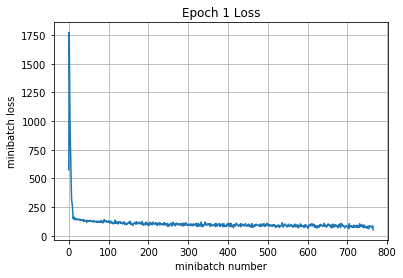

Iteration 800: with minibatch training loss = 1.47 and accuracy of 0.5
Iteration 900: with minibatch training loss = 1.49 and accuracy of 0.53
Iteration 1000: with minibatch training loss = 1.29 and accuracy of 0.53
Iteration 1100: with minibatch training loss = 1.07 and accuracy of 0.62
Iteration 1200: with minibatch training loss = 0.858 and accuracy of 0.58
Iteration 1300: with minibatch training loss = 1.05 and accuracy of 0.64
Iteration 1400: with minibatch training loss = 1.09 and accuracy of 0.7
Iteration 1500: with minibatch training loss = 1.16 and accuracy of 0.53
Epoch 2, Overall loss = 1.12 and accuracy of 0.602


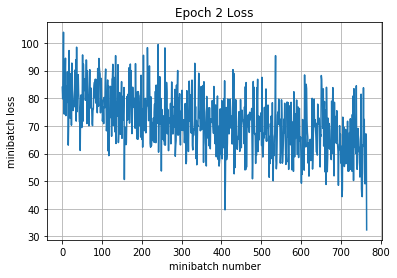

Iteration 1600: with minibatch training loss = 0.925 and accuracy of 0.67
Iteration 1700: with minibatch training loss = 1.31 and accuracy of 0.53
Iteration 1800: with minibatch training loss = 0.791 and accuracy of 0.73
Iteration 1900: with minibatch training loss = 1.03 and accuracy of 0.67
Iteration 2000: with minibatch training loss = 0.954 and accuracy of 0.67
Iteration 2100: with minibatch training loss = 0.887 and accuracy of 0.75
Iteration 2200: with minibatch training loss = 0.906 and accuracy of 0.73
Epoch 3, Overall loss = 0.848 and accuracy of 0.706


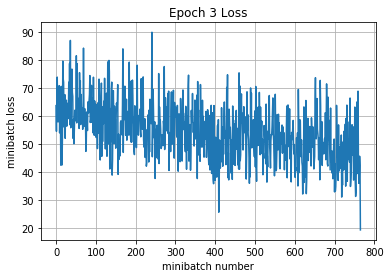

Iteration 2300: with minibatch training loss = 0.853 and accuracy of 0.69
Iteration 2400: with minibatch training loss = 0.635 and accuracy of 0.8
Iteration 2500: with minibatch training loss = 0.458 and accuracy of 0.84
Iteration 2600: with minibatch training loss = 0.494 and accuracy of 0.83
Iteration 2700: with minibatch training loss = 0.402 and accuracy of 0.91
Iteration 2800: with minibatch training loss = 0.802 and accuracy of 0.73
Iteration 2900: with minibatch training loss = 0.547 and accuracy of 0.8
Iteration 3000: with minibatch training loss = 0.459 and accuracy of 0.84
Epoch 4, Overall loss = 0.605 and accuracy of 0.791


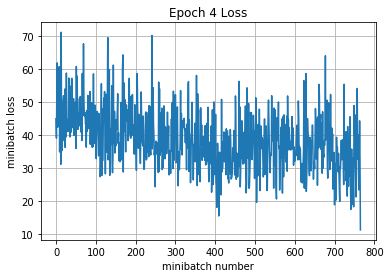

Iteration 3100: with minibatch training loss = 0.711 and accuracy of 0.73
Iteration 3200: with minibatch training loss = 0.331 and accuracy of 0.89
Iteration 3300: with minibatch training loss = 0.615 and accuracy of 0.81
Iteration 3400: with minibatch training loss = 0.429 and accuracy of 0.88
Iteration 3500: with minibatch training loss = 0.377 and accuracy of 0.89
Iteration 3600: with minibatch training loss = 0.366 and accuracy of 0.84
Iteration 3700: with minibatch training loss = 0.336 and accuracy of 0.88
Iteration 3800: with minibatch training loss = 0.337 and accuracy of 0.84
Epoch 5, Overall loss = 0.433 and accuracy of 0.85


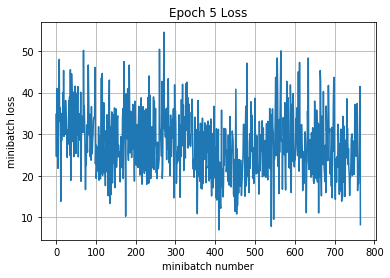

Iteration 0: with minibatch training loss = 0.719 and accuracy of 0.81
Iteration 100: with minibatch training loss = 0.432 and accuracy of 0.88
Iteration 200: with minibatch training loss = 0.481 and accuracy of 0.83
Iteration 300: with minibatch training loss = 0.497 and accuracy of 0.84
Iteration 400: with minibatch training loss = 0.174 and accuracy of 0.94
Iteration 500: with minibatch training loss = 0.304 and accuracy of 0.89
Iteration 600: with minibatch training loss = 0.497 and accuracy of 0.83
Iteration 700: with minibatch training loss = 0.552 and accuracy of 0.81
Epoch 1, Overall loss = 0.361 and accuracy of 0.875


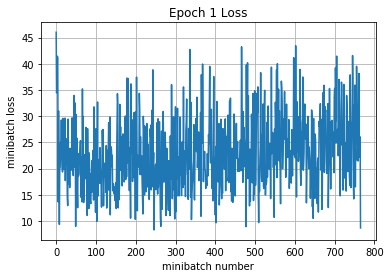

Iteration 800: with minibatch training loss = 0.115 and accuracy of 0.95
Iteration 900: with minibatch training loss = 0.122 and accuracy of 0.97
Iteration 1000: with minibatch training loss = 0.0844 and accuracy of 0.97
Iteration 1100: with minibatch training loss = 0.135 and accuracy of 0.92
Iteration 1200: with minibatch training loss = 0.132 and accuracy of 0.97
Iteration 1300: with minibatch training loss = 0.261 and accuracy of 0.92
Iteration 1400: with minibatch training loss = 0.28 and accuracy of 0.92
Iteration 1500: with minibatch training loss = 0.254 and accuracy of 0.88
Epoch 2, Overall loss = 0.165 and accuracy of 0.944


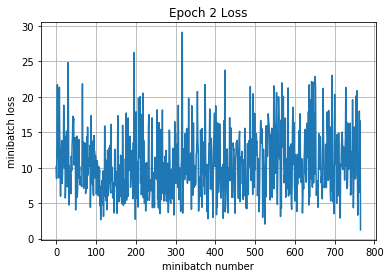

Iteration 1600: with minibatch training loss = 0.131 and accuracy of 0.97
Iteration 1700: with minibatch training loss = 0.137 and accuracy of 0.94
Iteration 1800: with minibatch training loss = 0.0466 and accuracy of 0.98
Iteration 1900: with minibatch training loss = 0.139 and accuracy of 0.94
Iteration 2000: with minibatch training loss = 0.132 and accuracy of 0.97
Iteration 2100: with minibatch training loss = 0.0814 and accuracy of 0.97
Iteration 2200: with minibatch training loss = 0.077 and accuracy of 0.97
Epoch 3, Overall loss = 0.152 and accuracy of 0.95


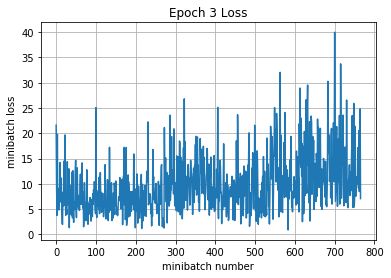

Iteration 2300: with minibatch training loss = 0.209 and accuracy of 0.92
Iteration 2400: with minibatch training loss = 0.0798 and accuracy of 0.98
Iteration 2500: with minibatch training loss = 0.232 and accuracy of 0.92
Iteration 2600: with minibatch training loss = 0.0434 and accuracy of 0.97
Iteration 2700: with minibatch training loss = 0.0522 and accuracy of 0.97
Iteration 2800: with minibatch training loss = 0.507 and accuracy of 0.91
Iteration 2900: with minibatch training loss = 0.0455 and accuracy of 1
Iteration 3000: with minibatch training loss = 0.146 and accuracy of 0.94
Epoch 4, Overall loss = 0.144 and accuracy of 0.951


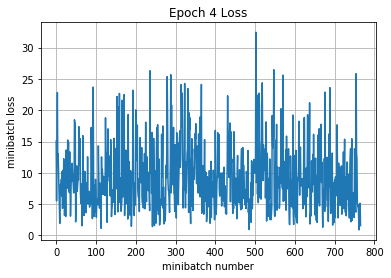

Iteration 3100: with minibatch training loss = 0.0826 and accuracy of 0.97
Iteration 3200: with minibatch training loss = 0.121 and accuracy of 0.94
Iteration 3300: with minibatch training loss = 0.088 and accuracy of 0.97
Iteration 3400: with minibatch training loss = 0.124 and accuracy of 0.95
Iteration 3500: with minibatch training loss = 0.23 and accuracy of 0.95
Iteration 3600: with minibatch training loss = 0.0404 and accuracy of 0.98
Iteration 3700: with minibatch training loss = 0.181 and accuracy of 0.94
Iteration 3800: with minibatch training loss = 0.101 and accuracy of 0.97
Epoch 5, Overall loss = 0.117 and accuracy of 0.962


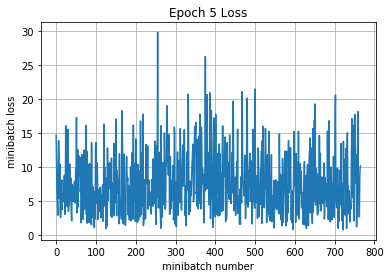

Iteration 0: with minibatch training loss = 0.182 and accuracy of 0.92
Iteration 100: with minibatch training loss = 0.0775 and accuracy of 0.97
Iteration 200: with minibatch training loss = 0.147 and accuracy of 0.95
Iteration 300: with minibatch training loss = 0.178 and accuracy of 0.94
Iteration 400: with minibatch training loss = 0.0322 and accuracy of 0.98
Iteration 500: with minibatch training loss = 0.184 and accuracy of 0.97
Iteration 600: with minibatch training loss = 0.352 and accuracy of 0.86
Iteration 700: with minibatch training loss = 0.18 and accuracy of 0.92
Epoch 1, Overall loss = 0.128 and accuracy of 0.958


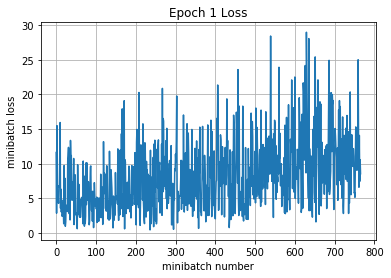

Iteration 800: with minibatch training loss = 0.0731 and accuracy of 0.97
Iteration 900: with minibatch training loss = 0.035 and accuracy of 1
Iteration 1000: with minibatch training loss = 0.0281 and accuracy of 0.98
Iteration 1100: with minibatch training loss = 0.17 and accuracy of 0.95
Iteration 1200: with minibatch training loss = 0.305 and accuracy of 0.94
Iteration 1300: with minibatch training loss = 0.0662 and accuracy of 0.97
Iteration 1400: with minibatch training loss = 0.0533 and accuracy of 0.98
Iteration 1500: with minibatch training loss = 0.186 and accuracy of 0.94
Epoch 2, Overall loss = 0.0967 and accuracy of 0.967


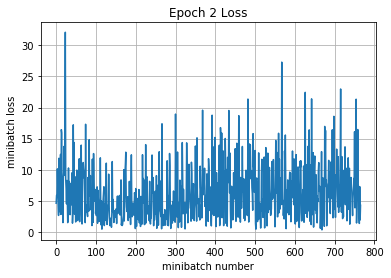

Iteration 1600: with minibatch training loss = 0.114 and accuracy of 0.95
Iteration 1700: with minibatch training loss = 0.0458 and accuracy of 0.98
Iteration 1800: with minibatch training loss = 0.0998 and accuracy of 0.97
Iteration 1900: with minibatch training loss = 0.0584 and accuracy of 0.97
Iteration 2000: with minibatch training loss = 0.155 and accuracy of 0.95
Iteration 2100: with minibatch training loss = 0.0891 and accuracy of 0.97
Iteration 2200: with minibatch training loss = 0.0349 and accuracy of 0.98
Epoch 3, Overall loss = 0.0969 and accuracy of 0.968


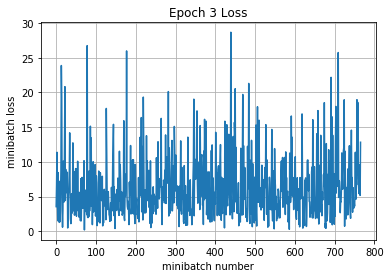

Iteration 2300: with minibatch training loss = 0.172 and accuracy of 0.95
Iteration 2400: with minibatch training loss = 0.139 and accuracy of 0.97
Iteration 2500: with minibatch training loss = 0.107 and accuracy of 0.97
Iteration 2600: with minibatch training loss = 0.0422 and accuracy of 0.98
Iteration 2700: with minibatch training loss = 0.2 and accuracy of 0.95
Iteration 2800: with minibatch training loss = 0.0299 and accuracy of 0.98
Iteration 2900: with minibatch training loss = 0.29 and accuracy of 0.94
Iteration 3000: with minibatch training loss = 0.206 and accuracy of 0.94
Epoch 4, Overall loss = 0.0909 and accuracy of 0.971


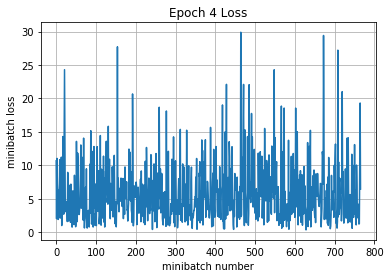

Iteration 3100: with minibatch training loss = 0.11 and accuracy of 0.94
Iteration 3200: with minibatch training loss = 0.0336 and accuracy of 1
Iteration 3300: with minibatch training loss = 0.0578 and accuracy of 0.98
Iteration 3400: with minibatch training loss = 0.00793 and accuracy of 1
Iteration 3500: with minibatch training loss = 0.0263 and accuracy of 1
Iteration 3600: with minibatch training loss = 0.0938 and accuracy of 0.98
Iteration 3700: with minibatch training loss = 0.00671 and accuracy of 1
Iteration 3800: with minibatch training loss = 0.0635 and accuracy of 0.98
Epoch 5, Overall loss = 0.086 and accuracy of 0.972


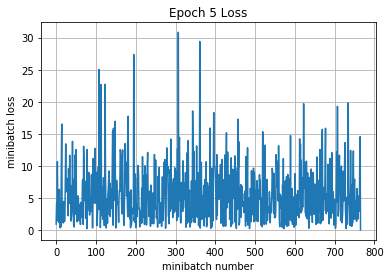

Iteration 0: with minibatch training loss = 0.0918 and accuracy of 0.95
Iteration 100: with minibatch training loss = 0.117 and accuracy of 0.95
Iteration 200: with minibatch training loss = 0.132 and accuracy of 0.98
Iteration 300: with minibatch training loss = 0.117 and accuracy of 0.98
Iteration 400: with minibatch training loss = 0.166 and accuracy of 0.95
Iteration 500: with minibatch training loss = 0.089 and accuracy of 0.97
Iteration 600: with minibatch training loss = 0.0315 and accuracy of 0.98
Iteration 700: with minibatch training loss = 0.134 and accuracy of 0.95
Epoch 1, Overall loss = 0.0973 and accuracy of 0.969


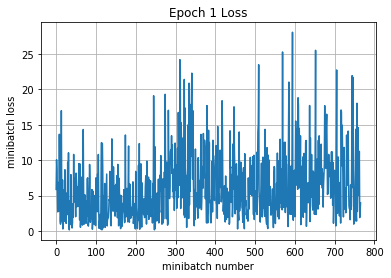

Iteration 800: with minibatch training loss = 0.189 and accuracy of 0.94
Iteration 900: with minibatch training loss = 0.318 and accuracy of 0.91
Iteration 1000: with minibatch training loss = 0.0701 and accuracy of 0.97
Iteration 1100: with minibatch training loss = 0.222 and accuracy of 0.91
Iteration 1200: with minibatch training loss = 0.228 and accuracy of 0.94
Iteration 1300: with minibatch training loss = 0.0849 and accuracy of 0.95
Iteration 1400: with minibatch training loss = 0.0071 and accuracy of 1
Iteration 1500: with minibatch training loss = 0.284 and accuracy of 0.97
Epoch 2, Overall loss = 0.0866 and accuracy of 0.973


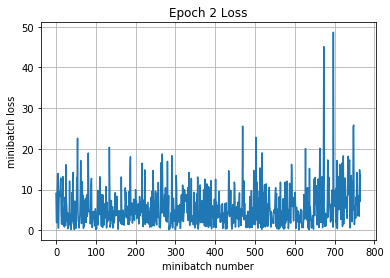

Iteration 1600: with minibatch training loss = 0.121 and accuracy of 0.97
Iteration 1700: with minibatch training loss = 0.0747 and accuracy of 0.97
Iteration 1800: with minibatch training loss = 0.176 and accuracy of 0.94
Iteration 1900: with minibatch training loss = 0.0385 and accuracy of 0.98
Iteration 2000: with minibatch training loss = 0.0859 and accuracy of 0.98
Iteration 2100: with minibatch training loss = 0.0726 and accuracy of 0.95
Iteration 2200: with minibatch training loss = 0.078 and accuracy of 0.98
Epoch 3, Overall loss = 0.0718 and accuracy of 0.977


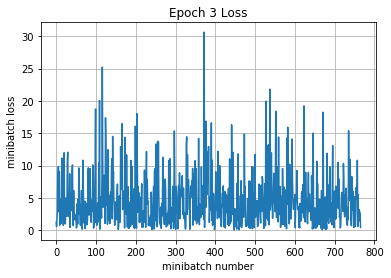

Iteration 2300: with minibatch training loss = 0.0614 and accuracy of 0.98
Iteration 2400: with minibatch training loss = 0.0187 and accuracy of 0.98
Iteration 2500: with minibatch training loss = 0.026 and accuracy of 0.98
Iteration 2600: with minibatch training loss = 0.0106 and accuracy of 1
Iteration 2700: with minibatch training loss = 0.127 and accuracy of 0.97
Iteration 2800: with minibatch training loss = 0.236 and accuracy of 0.97
Iteration 2900: with minibatch training loss = 0.0876 and accuracy of 0.97
Iteration 3000: with minibatch training loss = 0.00977 and accuracy of 1
Epoch 4, Overall loss = 0.0709 and accuracy of 0.977


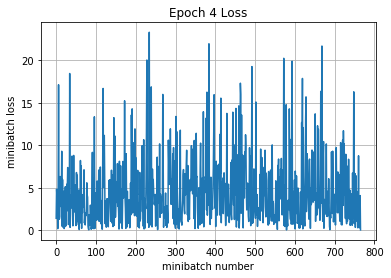

Iteration 3100: with minibatch training loss = 0.0074 and accuracy of 1
Iteration 3200: with minibatch training loss = 0.0111 and accuracy of 1
Iteration 3300: with minibatch training loss = 0.0915 and accuracy of 0.97
Iteration 3400: with minibatch training loss = 0.0108 and accuracy of 1
Iteration 3500: with minibatch training loss = 0.107 and accuracy of 0.97
Iteration 3600: with minibatch training loss = 0.0203 and accuracy of 1
Iteration 3700: with minibatch training loss = 0.0741 and accuracy of 0.95
Iteration 3800: with minibatch training loss = 0.0345 and accuracy of 0.98
Epoch 5, Overall loss = 0.0849 and accuracy of 0.974


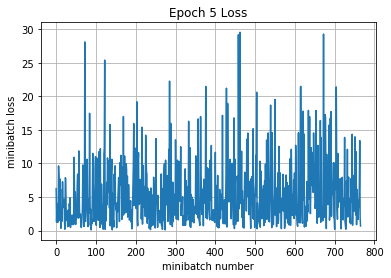

1 loops, best of 3: 42.8 s per loop
Validation
Epoch 1, Overall loss = 2.67 and accuracy of 0.661


In [8]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

y_out = my_model(X,y,is_training)
total_loss = tf.losses.softmax_cross_entropy(tf.one_hot(y, 10), logits=y_out)
mean_loss = tf.reduce_mean(total_loss)

# set up optimizer
learning_rate = 5e-4
optimizer = tf.train.AdamOptimizer(learning_rate)


# pass?

# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss)
    
    sess = tf.Session()
with tf.device("/gpu:0"):
    sess.run(tf.global_variables_initializer())
    print('Training')
    %timeit run_model(sess,y_out,mean_loss,X_train,y_train,5,64,100,train_step,True)
    print('Validation')
    run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

#### The cell below is not right...

In [6]:
# Test your model here, and make sure 
# the output of this cell is the accuracy
# of your best model on the training and val sets
# We're looking for >= 70% accuracy on Validation
print('Training')
run_model(sess,y_out,mean_loss,X_train,y_train,1,64)
print('Validation')
run_model(sess,y_out,mean_loss,X_val,y_val,1,64)

Training
Epoch 1, Overall loss = 0.262 and accuracy of 0.918
Validation
Epoch 1, Overall loss = 2.15 and accuracy of 0.629


(2.1484362449645995, 0.629)

## Testing

In [ ]:
print('Test')
run_model(sess,y_out,mean_loss,X_test,y_test,1,64)

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these; however they would be good things to try for extra credit.

- Alternative update steps: For the assignment we implemented SGD+momentum, RMSprop, and Adam; you could try alternatives like AdaGrad or AdaDelta.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)
